# User-provided Templates

One of the most powerful built-in features of the {{bfrescox}} package is its ability to run user-defined **template input files** for any desired reaction calculation.  

A **template input file** is a {{frescox}} namelist file that contains:
1. Information about the reaction that remains **static** between subsequent calculations ({{ie}} the target or projectile mass, spin, {{etc}}).  
2. **Placeholder** values representing the **dynamical** part of the calculation ({{ie}} the interaction parameters that may vary between runs).

As an example of how to use a user-provided template, we will consider neutron elastic scattering on a $ ^{48} $ Ca target at 7.97 MeV energy in the laboratory frame. The steps to set up this simple example can be broadly generalized to any {{frescox}} input. 


In [28]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import inspect
import pandas as pd
import json

with open("MatplotlibEsthetics.json", "r") as fptr:
    esthetics = json.load(fptr)

plt.style.use(esthetics["style"])
FONTSIZE      = esthetics["fontsize"]
TICK_FONTSIZE = esthetics["tick_fontsize"]
MARKERSIZE    = esthetics["markersize"]
LINEWIDTH     = esthetics["linewidth"]

## Creating a template
The first step to running this functionality of {{bfrescox}} is to obtain the desired template. Let's provide the appropriate path to the template we wish to use, then let's create a folder where all the {{frescox}} output files will be written to. 

In [29]:
import bfrescox

# name of template
TEMPLATE_NAME = "48Ca_Ozge.template"

# path to template directory
TEMPLATE_DIR = (
    Path(inspect.getfile(bfrescox))
    .resolve()
    .parent
    .joinpath("tests", "TestData")
)

# full path to template file
TEMPLATE_PATH = TEMPLATE_DIR.joinpath(TEMPLATE_NAME)



# Folder to which all frescox input/output files will be written to
EXAMPLE_DIR = Path.cwd().joinpath("Ozge_template")
if EXAMPLE_DIR.exists():
    shutil.rmtree(EXAMPLE_DIR)
os.mkdir(EXAMPLE_DIR)


Great, let's see what it looks like!

In [30]:
with open(TEMPLATE_PATH, "r") as temp:
    generated_content = temp.read()

print("Frescox User-Defined Template:")
print("-----------------------------------")
print(generated_content)

Frescox User-Defined Template:
-----------------------------------
48Ca scattering
NAMELIST
 &FRESCO hcm=0.01 rmatch=40 rintp=0.20 hnl=@hnl@ rnl=@rnl@ centre=-0.25
	 jtmin=0.0  jtmax=35 absend=-1.0
	 thmin=0.00 thmax=180.00 thinc=1.0
	 iter=0 iblock=2 nnu=36
	 chans=1 treneg=1 xstabl=1
         elab(1)= 7.97 /

 &PARTITION namep='n'  massp=1.0 zp=0
            namet='48Ca'  masst= 48. zt=20  nex=1  /
 &STATES jp=0.5 bandp=1 ep=0.0 cpot=1 jt= 0 bandt= 1 et=0.0000 /
 &partition /

  &pot kp= 1 type= 0  p(1:3)= 1.000  48.  0.00 /
  &pot kp= 1 type= 1  p(1:6)= @V@    @r@    @a@     1.0  1.33  0.62 /
  &pot kp= 1 type= 2  p(1:6)= 0.0    0.0    0.0     @Ws@ @rs@  @as@ /
  &pot kp= 1 type= 3  p(1:6)= 6.6    1.33   0.62    0.0  1.36  0.63 /
  &pot /
 &overlap /
 &COUPLING /



As can be identified in this template, the **dynamic** components of the calculation correspond to the interaction Woods–Saxon parameters (labeled as $\texttt{@<parameter-name>@}$) and the parameters associated with the non-local Numerov integration in {{frescox}} ({{ie}} $\texttt{@hnl@}$ and $\texttt{@rnl@}$). These **placeholder** values are replaced with user-defined numerical inputs during each calculation. All remaining entries in the template represent the **static** part of the configuration.  



## Replacing the **placeholders** and generating the {{frescox}} input

Using the `bfrescox.Configuration.from_template()` method, we are able to pass through the numerical values that will replace the **placeholders** and allow us generate the final {{frescox}} input. We can easily do this using a Python dictionary. 

In [31]:
# you can now pass the parameter values to bfrescox as a dictionary, matching the placeholder names
user_defined_parameters =   {
                    "hnl":  0.1,
                    "rnl": 5.0,
                    "V":  49.284900,
                    "r":   0.907039,
                    "a":   0.679841,
                    "Ws":  3.394386,
                    "rs":  1.094115,
                    "as":  0.2763
                }


# Create the frescox input file by filling in the user-defined template with parameters
cfg = bfrescox.Configuration.from_template(
                    TEMPLATE_PATH,
                    EXAMPLE_DIR.joinpath("frescox.in"),
                    user_defined_parameters,
                    overwrite=True,
                )

Awesome! We now have removed the **placeholders** and we are ready to run {{bfrescox}}. Before doing this, let's see what the final template looks like!

In [32]:
with open(EXAMPLE_DIR.joinpath("frescox.in"), "r") as input:
    generated_content = input.read()

print("Frescox User-Defined Input:")
print("-----------------------------------")
print(generated_content)

Frescox User-Defined Input:
-----------------------------------
48Ca scattering
NAMELIST
 &FRESCO hcm=0.01 rmatch=40 rintp=0.20 hnl=0.100000000 rnl=5.000000000 centre=-0.25
	 jtmin=0.0  jtmax=35 absend=-1.0
	 thmin=0.00 thmax=180.00 thinc=1.0
	 iter=0 iblock=2 nnu=36
	 chans=1 treneg=1 xstabl=1
         elab(1)= 7.97 /

 &PARTITION namep='n'  massp=1.0 zp=0
            namet='48Ca'  masst= 48. zt=20  nex=1  /
 &STATES jp=0.5 bandp=1 ep=0.0 cpot=1 jt= 0 bandt= 1 et=0.0000 /
 &partition /

  &pot kp= 1 type= 0  p(1:3)= 1.000  48.  0.00 /
  &pot kp= 1 type= 1  p(1:6)= 49.284900000    0.907039000    0.679841000     1.0  1.33  0.62 /
  &pot kp= 1 type= 2  p(1:6)= 0.0    0.0    0.0     3.394386000 1.094115000  0.276300000 /
  &pot kp= 1 type= 3  p(1:6)= 6.6    1.33   0.62    0.0  1.36  0.63 /
  &pot /
 &overlap /
 &COUPLING /



## Running the user-provided input with {{bfrescox}}

Once the {{frescox}} input file is generate, running the calculation is extremely easy!

In [33]:
# Run the frescox simulation
bfrescox.run_simulation(cfg, EXAMPLE_DIR.joinpath("frescox.out"), cwd=EXAMPLE_DIR, overwrite=True)

Done! All that is left is to parse the results we want to look at.

## Step 4: Parsing the output

In general, {{frescox}} writes the cross sections in the **fort.16** file.  Let's extract those cross sections for our example case as a DataFrame.

In [35]:
results = bfrescox.parse_fort16(EXAMPLE_DIR.joinpath("fort.16"))
display(results["channel_1"].head())

,Theta,sigma
0,0.01,2286.0
1,1.00,2283.0
2,2.00,2275.0
3,3.00,2261.0
4,4.00,2241.0


## Visualizing cross sections

Now that we have the cross sections in a Dataframe, let's visualize them.

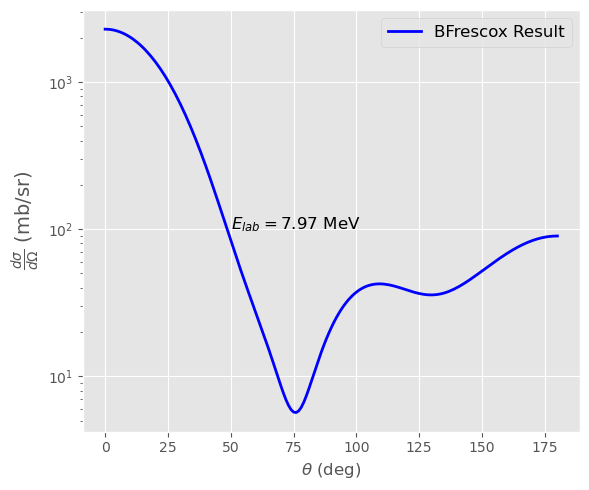

In [36]:
angles_deg = results["channel_1"]["Theta"].to_numpy()
diff_xs_mb_per_sr = results["channel_1"]["sigma"].to_numpy()


# Create single figure and axis
fig, ax1 = plt.subplots(figsize=(6, 5))

# Global font size settings for ticks
ax1.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
ax1.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)

# Plot differential cross section
ax1.plot(angles_deg, diff_xs_mb_per_sr, lw=LINEWIDTH, color='blue', label='BFrescox Result')
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=14)
ax1.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)

# Add annotation
ax1.text(50.0, 1e2, r"$E_{lab} = 7.97$ MeV",
         fontsize=FONTSIZE, color='black')

plt.legend(fontsize=FONTSIZE)

plt.tight_layout()
plt.show()